In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

from sklearn.cluster import AgglomerativeClustering

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

### Prerequisite loading

In [3]:
scale = 1
connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]
thresh_subjapp = int(np.ceil(nsubject * 0.1)) 

fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
rest_affine = voxel_fmri.affine

In [5]:
# Load the rest fmri in MNI space volumes
ftimecourse = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').get_fdata()
rest_affine = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii').affine

# Visualize the corresponding probabilstic voxels for this region
root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'
atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'
prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)

# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()

In [6]:
thresh_subjapp = int(np.ceil(nsubject * 0.1))
bundle_affine = np.array(hf.get('header').get('affine'))[()]

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))

100%|██████████| 95/95 [00:21<00:00,  4.42it/s]


### Visualize activity inpainted by edge value

In [12]:
region_ftimecourse = load(f"../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95_scale{scale}.pkl")

In [16]:
# Compute edge activity - through Betzel idea
bundle_opt = np.zeros((region_ftimecourse.shape[-1], len(bundles_labels)))
for pidx, pair in enumerate(bundles_labels):
    i,j = pair
    bundle_opt[:,pidx] = zscore(region_ftimecourse[i-1] * region_ftimecourse[j-1])

In [19]:
inpainted_array = []
for k in tqdm(range(ftimecourse.shape[-1])):
    tmp_inpainted, tmp_inpainted2 = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False)
    inpainted_array.append(tmp_inpainted2)
inpainted_array = np.array(inpainted_array)

100%|██████████| 460/460 [05:20<00:00,  1.44it/s]


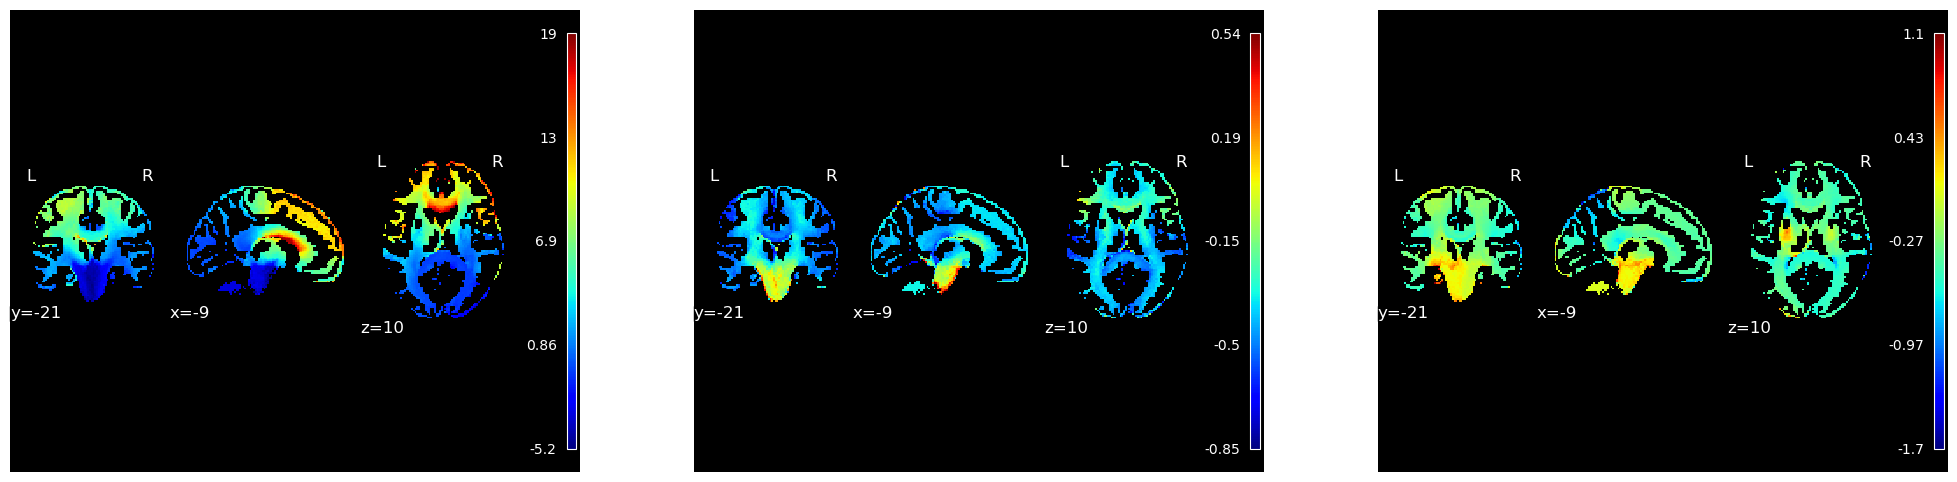

In [25]:
cmap = mpl.colormaps.get_cmap('jet')
cmap.set_extremes(under='black', over='black')

samples = [0, 150, 300]
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
for k in range(len(samples)):

    inpaint_mod = deepcopy(inpainted_array[samples[k]])
    # inpaint_mod[inpaint_mod!=0] = inpaint_mod[inpaint_mod!=0] - inpaint_mod[inpaint_mod!=0].mean()
    vmin = np.quantile(inpaint_mod[inpaint_mod > -100000], 0.001)
    vmax = np.quantile(inpaint_mod[inpaint_mod > -100000], 0.999)
    plot_epi(nib.Nifti1Image(inpaint_mod, affine=rest_affine),
                         colorbar=True, cut_coords=(-9,-21,10), axes=ax[k],
                        cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=False)

### Timewise clustering and average (CAPS like)

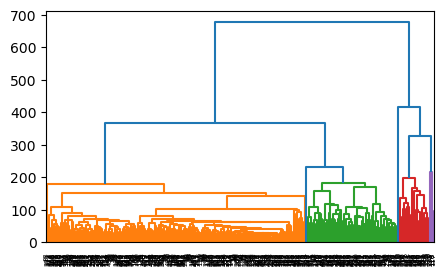

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage

ethresh = 220
fig, ax = plt.subplots(1, figsize=(5,3))
linkage_data = linkage(bundle_opt, method='ward', metric='euclidean')
linkage_data_cosine = linkage(bundle_opt, method='average', metric='cosine')
dendrogram(linkage_data, ax=ax, color_threshold=ethresh)
plt.show()

In [28]:
cluster_ward = AgglomerativeClustering(
    n_clusters=None, affinity='euclidean', linkage='ward', compute_full_tree=True, distance_threshold=ethresh)

cluster_ward.fit(bundle_opt)
labels_ward = cluster_ward.labels_

nb_clusterward = len(np.unique(labels_ward))

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [30]:
new_inpainted_array = deepcopy(inpainted_array)
new_inpainted_array[new_inpainted_array==-100000] = 0
patterns = [new_inpainted_array[labels_ward==k].mean(axis=0) for k in range(nb_clusterward)]

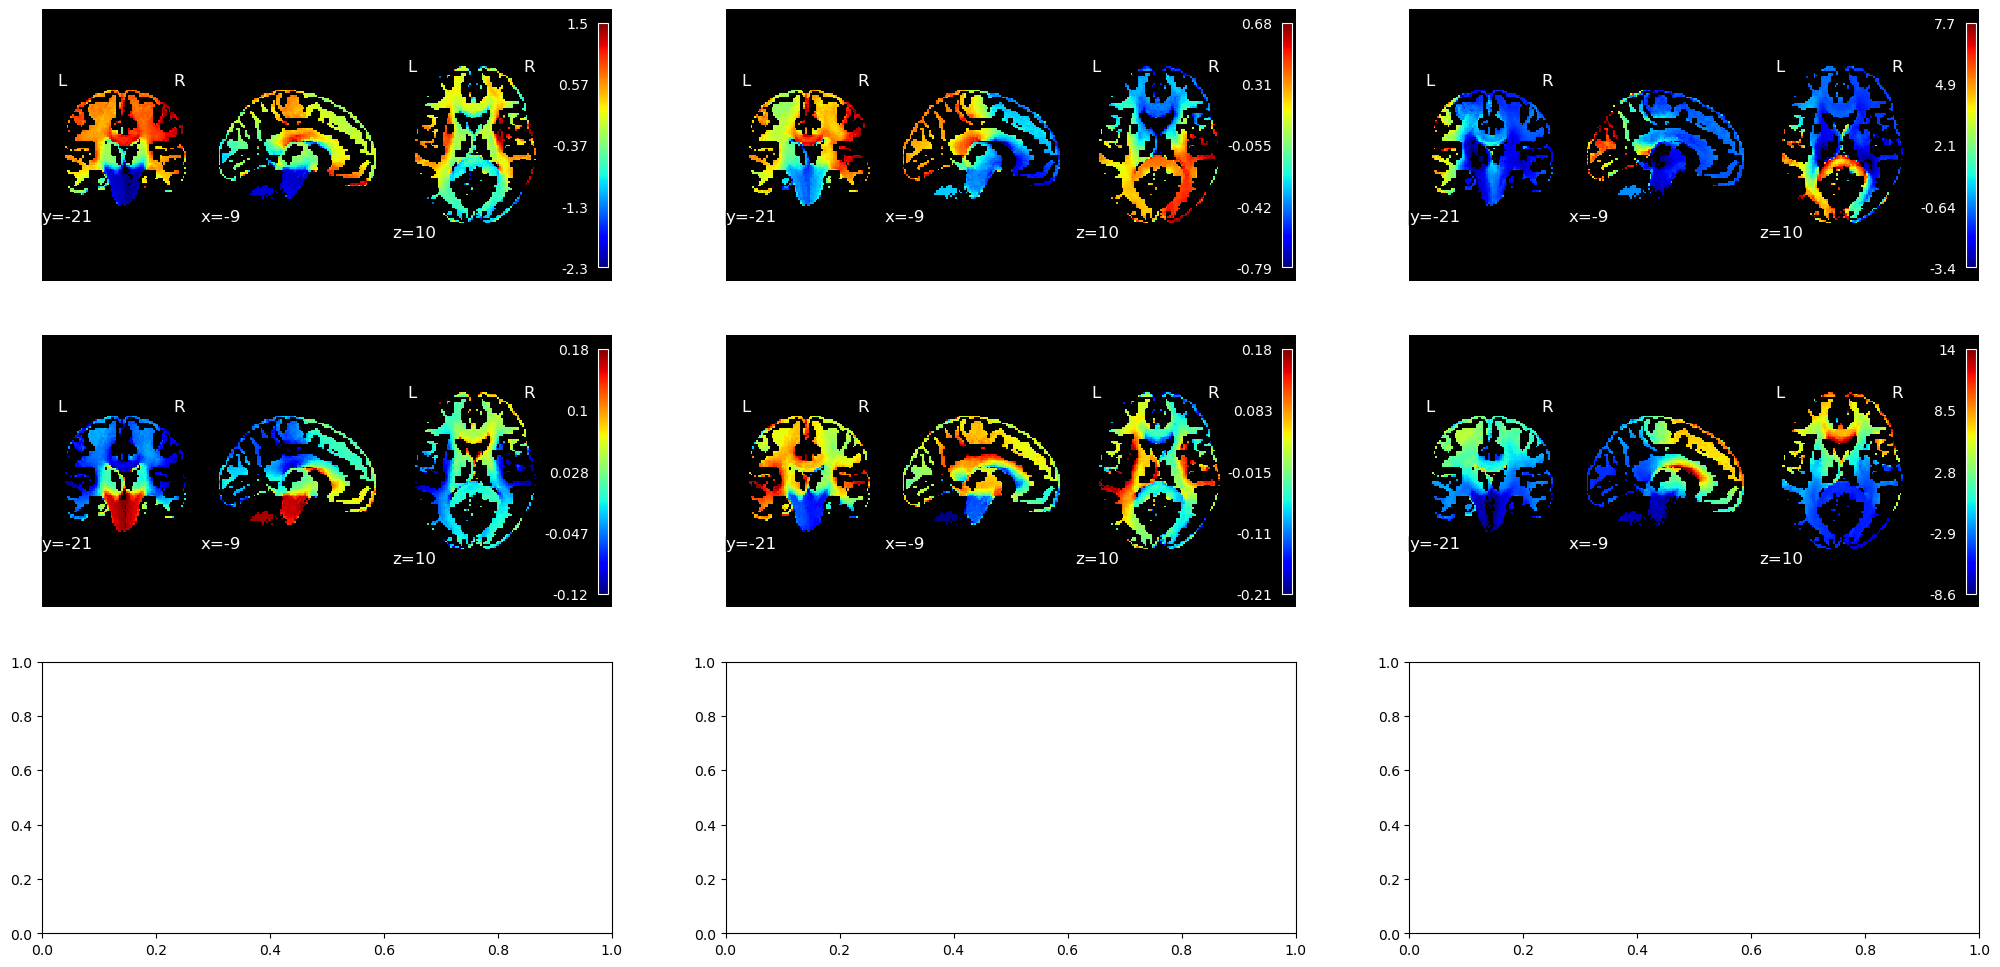

In [31]:
fig, ax = plt.subplots(nb_clusterward//3+1, 3, figsize=(25, nb_clusterward*2))
for k in range(nb_clusterward):

    inpaint_mod = deepcopy(patterns[k])
    inpaint_mod[inpaint_mod!=0] = inpaint_mod[inpaint_mod!=0] - inpaint_mod[inpaint_mod!=0].mean()
    vmin = np.quantile(inpaint_mod, 0.001)
    vmax = np.quantile(inpaint_mod, 0.999)
    inpaint_mod[inpaint_mod==0] = -10000
    plot_epi(nib.Nifti1Image(inpaint_mod, affine=rest_affine),
                         colorbar=True, cut_coords=(-9,-21,10), axes=ax[k//3,k%3],
                        cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=False)